# Leagues Comparison

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import networkx as nx
from collections import Counter

data_partite = pd.read_csv("data_1/data_matches.csv", encoding='latin-1')
campionati = pd.read_csv("data_1/leagues.csv", encoding='latin-1')

In [2]:
def transformation(dataset, column, retain, new_col_names):
    new_data = dataset.merge(campionati, left_on= column, right_on = "Squad", how='outer').fillna(0)
    new_data = new_data[(new_data['League'] != 0) & (new_data[column] != 0)]
    new_data = new_data[retain]
    new_data.columns = new_col_names
    new_data['DR'] = new_data['DR'].apply(lambda x: int(x))
    new_data = new_data.reset_index()
    new_data = new_data.drop(['index'],axis = 1)
    return new_data

df3 = transformation(data_partite, 'Home_Team', ["League","Away_Team","Winner","DR"], ['Home_Team',"Away_Team","Winner","DR"])
df4 = transformation(df3, "Away_Team", ["Home_Team","League","Winner","DR"], ['Home_Team',"Away_Team","Winner","DR"])
df5 = transformation(df4, "Winner", ["Home_Team","Away_Team","League","DR"], ['Home_League',"Away_League","Winner","DR"])

df5 = df5[df5["Home_League"] != df5["Away_League"]]
df5 = df5.reset_index()
df5 = df5.drop(['index'],axis = 1)

In [3]:
listone = [(df5['Home_League'][i], df5['Away_League'][i]) for i in range(len(df5))]
hh = Counter(listone).most_common()

nuova_lista = {}

for i in range(len(hh)):
    if (hh[i][0] not in nuova_lista.keys()) & ((hh[i][0][1], hh[i][0][0]) not in nuova_lista.keys()):
        nuova_lista[hh[i][0]] = hh[i][1]
    elif (hh[i][0] not in nuova_lista.keys()) & ((hh[i][0][1], hh[i][0][0]) in nuova_lista.keys()):
        nuova_lista[(hh[i][0][1], hh[i][0][0])] += hh[i][1]
    elif (hh[i][0] in nuova_lista.keys()) & ((hh[i][0][1], hh[i][0][0]) in nuova_lista.keys()):
        nuova_lista[hh[i][0]] += hh[i][1]

In [4]:
df_a = pd.DataFrame(index = df5.Home_League.unique(),columns = df5.Home_League.unique())
df_a = df_a.fillna(0)

nazioni = df5.Home_League.unique()

for i in range(len(df5)):
    a = Counter(df5.iloc[i][:3].values)
    rev = {v: k for k, v in a.items()}
    loser = rev[1]
    df_a[df5.iloc[i]['Winner']][loser] += df5.iloc[i][3]
    
for i in range(len(list(nuova_lista.keys()))):
    df_a.loc[list(nuova_lista.keys())[i][0],list(nuova_lista.keys())[i][1]] /= nuova_lista[list(nuova_lista.keys())[i]]
    df_a.loc[list(nuova_lista.keys())[i][1],list(nuova_lista.keys())[i][0]] /= nuova_lista[list(nuova_lista.keys())[i]]
    
v = pd.DataFrame(columns = ['vincente',"perdente","di quanto"])
for k in range(len(df_a)):
    for j in range(len(df_a)):
        v = v.append({'vincente': df_a.index[k],'perdente': df_a[df_a.index[k]].index[j],'di quanto':df_a[df_a.index[k]][j]}, ignore_index = True)

v = v[v['vincente'] != v['perdente']]

In [5]:
a = list(set([i for i in v['vincente']]))
b = list(set([i for i in v['perdente']]))
c = list(set(a+b))
subset = v[['perdente', 'vincente','di quanto']]
tuples = [tuple(x) for x in subset.to_numpy()]
tuples = [x for x in tuples if x[2] != 0] 

G = nx.DiGraph()
G.add_nodes_from(c)
G.add_weighted_edges_from(tuples)
G.in_edges(data=True)

InEdgeDataView([('Swiss Super League', 'Serie A', {'weight': 1.0}), ('Ligue 1', 'Serie A', {'weight': 1.0217391304347827}), ('Premier League', 'Serie A', {'weight': 0.8732394366197183}), ('Cypro League', 'Serie A', {'weight': 1.6666666666666667}), ('Bundesliga', 'Serie A', {'weight': 0.6909090909090909}), ('Denmark League', 'Serie A', {'weight': 3.125}), ('Divizia Nasional', 'Serie A', {'weight': 2.0}), ('HNL 1', 'Serie A', {'weight': 1.3333333333333333}), ('Ukraine League', 'Serie A', {'weight': 1.2352941176470589}), ('Eredivisie', 'Serie A', {'weight': 0.7222222222222222}), ('Czech League', 'Serie A', {'weight': 1.4705882352941178}), ('Sweden League', 'Serie A', {'weight': 1.9}), ('Turkish League', 'Serie A', {'weight': 1.7857142857142858}), ('Belgian League', 'Serie A', {'weight': 1.8571428571428572}), ('Bulgarian League', 'Serie A', {'weight': 1.6428571428571428}), ('Liga Portuguesa', 'Serie A', {'weight': 1.0}), ('La Liga', 'Serie A', {'weight': 0.5975609756097561}), ('Russian Lea

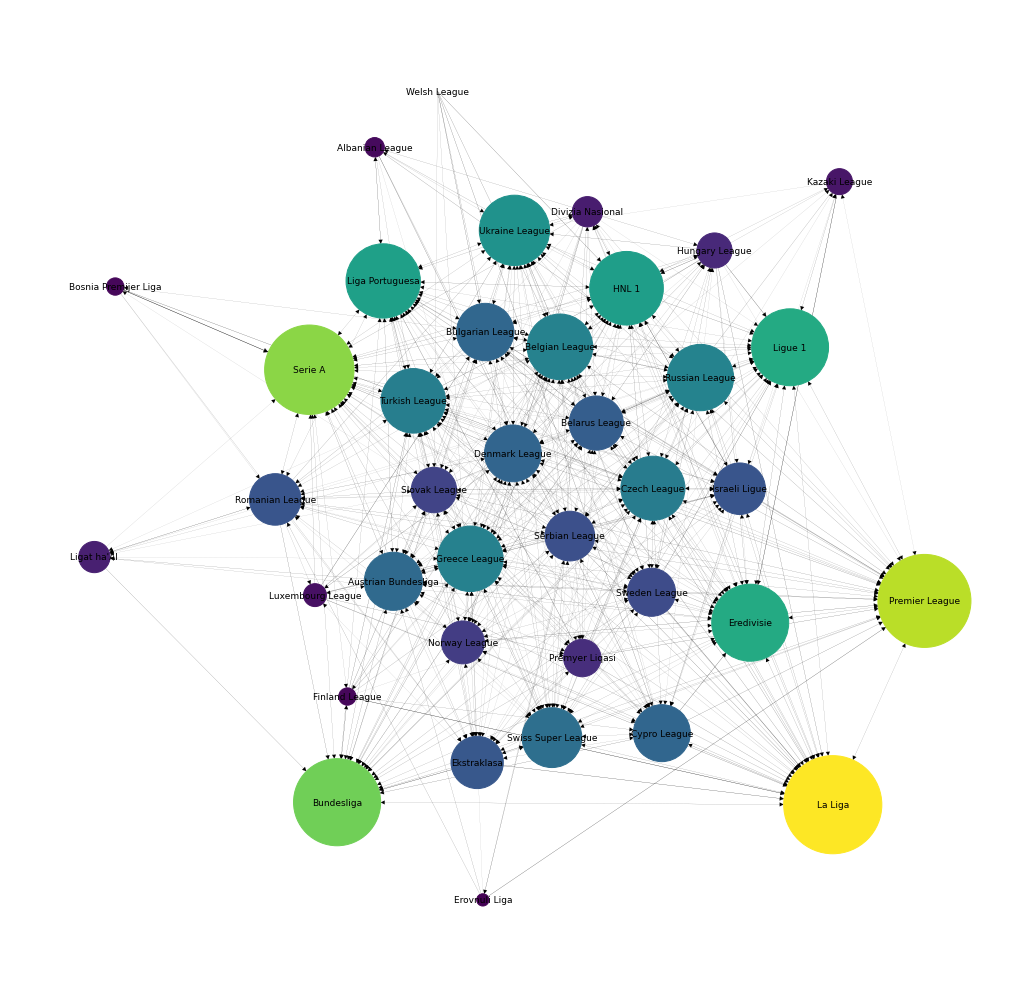

In [10]:
pos = nx.spring_layout(G, weight = 'weight', iterations=50000, threshold=0.000001)

node_size = [150 * G.in_degree(i) * np.mean([k[2]['weight'] for k in list(G.in_edges(i,data = True))]) for i in G]
node_color = [50 * G.in_degree(i) * np.mean([k[2]['weight'] for k in list(G.in_edges(i,data = True))]) for i in G]
weights = [G[i][j]['weight'] * 0.05 for i,j in G.edges()]

plt.figure(figsize = (18,18))
           
nx.draw_networkx(G, 
                 pos,
                 with_labels = False,
                 node_color = node_color,
                 node_size = node_size, 
                 width = weights)

nx.draw_networkx_labels(G, pos = pos, font_color = "black", font_size = 9)

plt.box(on = None)
plt.axis('off')

plt.show()

In [7]:
lista_j = [[i, G.in_degree(i) * np.mean([k[2]['weight'] for k in list(G.in_edges(i,data = True))])] for i in G]
lista_j = [j for j in lista_j if ~np.isnan(j[1])]

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

X = [G.in_degree(i) * np.mean([k[2]['weight'] for k in list(G.in_edges(i,data = True))]) for i in G]
X = [j for j in X if ~np.isnan(j)]
X.append(0)

scaled_x = NormalizeData(X)

y = [[lista_j[i][0], scaled_x[i]] for i in range(len(lista_j))]

diz={}

for i in range(len(y)):
    diz[y[i][0]] = y[i][1]
    
diz = {k: v for k, v in sorted(diz.items(), key=lambda item: item[1], reverse=True)}
diz

{'La Liga': 1.0,
 'Premier League': 0.8982607461097232,
 'Serie A': 0.8300297363167998,
 'Bundesliga': 0.7876546461399606,
 'Eredivisie': 0.6151174428660068,
 'Ligue 1': 0.6140089636557122,
 'Liga Portuguesa': 0.5731314385753985,
 'HNL 1': 0.5626121164797088,
 'Ukraine League': 0.5131584033772475,
 'Russian League': 0.45704917919352417,
 'Belgian League': 0.44706923390609216,
 'Greece League': 0.4454213872577271,
 'Turkish League': 0.43283976589002265,
 'Czech League': 0.42604562377117794,
 'Swiss Super League': 0.3715489272319347,
 'Austrian Bundesliga': 0.3503189879344409,
 'Bulgarian League': 0.3410379468383694,
 'Cypro League': 0.3368529047950675,
 'Denmark League': 0.3344662678505183,
 'Belarus League': 0.3040973240179713,
 'Ekstraklasa': 0.2837215796516897,
 'Romanian League': 0.2757037604813364,
 'Israeli Ligue': 0.27565147761263303,
 'Serbian League': 0.2562460398361926,
 'Sweden League': 0.23977779545798522,
 'Slovak League': 0.21395458597533157,
 'Norway League': 0.1910989847

In [8]:
second_ranking = pd.read_html('https://www.globalfootballrankings.com/')[0]
second_ranking = second_ranking[['League','Average SPI']]
second_ranking['League'] = ['Premier League', 'La Liga', 'Bundesliga', 'Serie A', 'Ligue 1', 'Liga Portuguesa', 'Eredivisie', 'Brasileiro Série A', 'Mexican Primera Division Torneo Clausura', 'Russian League', 'English League Championship', 'Austrian Bundesliga','Belgian League', 'Turkish League', 'Swiss Super League', 'Denmark League', 'MLS', 'Argentina Primera Division', 'Scottish Premiership', 'Japanese J League' , 'German 2. Bundesliga', 'Greece League', 'Norway League', 'Italy Serie B','Spanish Segunda Division', 'French Ligue 2','Sweden League', 'Chinese Super League','Australian A-League', 'English League One','United Soccer League', 'South African ABSA Premier League', 'English League Two']

lista_SPI = [i for i in second_ranking['Average SPI']]
lista_SPI.append(0)

scaled_SPI = NormalizeData(lista_SPI)

diz2={}

for i in range(len(second_ranking)):
    diz2[second_ranking['League'][i]] = scaled_SPI[i]
    
diz2

{'Premier League': 1.0,
 'La Liga': 0.9570686354935739,
 'Bundesliga': 0.9469510527754991,
 'Serie A': 0.8777686628383922,
 'Ligue 1': 0.8310090237899918,
 'Liga Portuguesa': 0.7152037188952693,
 'Eredivisie': 0.7031719989062073,
 'Brasileiro Série A': 0.6743232157506153,
 'Mexican Primera Division Torneo Clausura': 0.6486190866830736,
 'Russian League': 0.6253759912496583,
 'English League Championship': 0.6028165162701669,
 'Austrian Bundesliga': 0.5905113480995351,
 'Belgian League': 0.5854525567404977,
 'Turkish League': 0.5455291222313371,
 'Swiss Super League': 0.5418375717801477,
 'Denmark League': 0.540333606781515,
 'MLS': 0.5392398140552365,
 'Argentina Primera Division': 0.5314465408805031,
 'Scottish Premiership': 0.5255674049767569,
 'Japanese J League': 0.48523379819524204,
 'German 2. Bundesliga': 0.4830462127426852,
 'Greece League': 0.4681432868471425,
 'Norway League': 0.4500957068635494,
 'Italy Serie B': 0.4364232977850698,
 'Spanish Segunda Division': 0.43505605687

In [9]:
nuovo1 = pd.DataFrame.from_dict(diz2, orient='index')
nuovo1 = nuovo1.reset_index()
nuovo1.columns = ["League","SPI Index"]
nuovo2 = pd.DataFrame.from_dict(diz, orient='index')
nuovo2 = nuovo2.reset_index()
nuovo2.columns = ["League","Graph Index"]
nuovo3 = pd.merge(nuovo1, nuovo2, on = "League")
nuovo3['Tot Index'] = (nuovo3['SPI Index'] + nuovo3['Graph Index'])/2

valore_nuovo = [i for i in nuovo3['Tot Index']]
valore_nuovo.append(0)
scaled_tot = NormalizeData(valore_nuovo)

y = [[nuovo3['League'][i], scaled_tot[i]] for i in range(len(nuovo3['League']))]

diz={}

for i in range(len(y)):
    diz[y[i][0]] = y[i][1]
    
diz = {k: v for k, v in sorted(diz.items(), key=lambda item: item[1], reverse=True)}
diz

{'La Liga': 1.0,
 'Premier League': 0.9699510337464382,
 'Bundesliga': 0.8863284953100233,
 'Serie A': 0.872630815385013,
 'Ligue 1': 0.738358359660324,
 'Eredivisie': 0.6736040922957925,
 'Liga Portuguesa': 0.6582984030837268,
 'Russian League': 0.5530849306009108,
 'Belgian League': 0.5275858863203269,
 'Turkish League': 0.4999154707083712,
 'Austrian Bundesliga': 0.4807344612094803,
 'Greece League': 0.466802572754158,
 'Swiss Super League': 0.4667115309329587,
 'Denmark League': 0.4469949897344343,
 'Norway League': 0.3276301505204768,
 'Sweden League': 0.31924932206089873}